In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import compress
from scipy import stats
import random
from bisect import bisect
import warnings

In [3]:
data = pd.read_csv(r"C:\Users\justi\Coding\Project\Han Xu\dataset_trimmed_v2.csv")

In [4]:
oncogenes = pd.read_csv(r"C:\Users\justi\Coding\Project\Han Xu\oncogene.txt").to_numpy().flatten()
oncogenes = np.append(oncogenes,'MYCL')
oncogenes = np.array(list(set(oncogenes).intersection(data.iloc[:,0])))
oncogenes.size

62

In [5]:
input_data = data.copy()
input_data['oncogene'] = np.isin(data.iloc[:,0], oncogenes)
positive = input_data.iloc[list(compress(range(len(input_data)), input_data.iloc[:,-1]))].reset_index(drop=True)
negative = input_data.drop(list(compress(range(len(input_data)), input_data.iloc[:,-1]))).reset_index(drop=True)
input_data

,gene name,gene_exp.copy_num.0,gene_exp.copy_num.1,gene_exp.copy_num.2,gene_exp.copy_num.3,gene_exp.copy_num.4,gene_exp.copy_num.5,gene_exp.copy_num.6,gene_exp.copy_num.7,gene_exp.copy_num.8,...,gene_mut.CRISPR.5,gene_mut.CRISPR.6,gene_mut.CRISPR.7,gene_mut.CRISPR.8,gene_mut.CRISPR.9,gene_mut.CRISPR.10,gene_mut.CRISPR.11,gene_mut.CRISPR.12,gene_mut.CRISPR.13,oncogene
0,A1BG,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.118440,...,-3.201021,-5.819234,-6.671945,-6.628317,-5.493931,-4.052666,-4.288081,-5.905126,-6.654196,False
1,A1CF,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,...,-3.589475,-6.307292,-6.671578,-6.539213,-4.854680,-3.489741,-3.998311,-5.907700,-6.655811,False
2,A2M,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,...,-4.878248,-6.515009,-6.656328,-5.852582,-3.893201,-3.336245,-4.560143,-6.400044,-6.670077,False
3,A2ML1,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,...,-2.641586,-5.327741,-6.671650,-6.560098,-4.958254,-3.241637,-3.136396,-4.856608,-6.578655,False
4,A4GALT,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,...,-4.604324,-6.400253,-6.669687,-6.446942,-5.251609,-4.752306,-5.667741,-6.603665,-6.671719,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15300,ZXDC,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.066659,...,-3.150751,-5.776114,-6.669076,-6.429197,-5.029861,-3.883235,-4.134244,-5.694593,-6.636581,False
15301,ZYG11A,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,...,-3.529519,-5.938482,-6.671310,-6.519521,-4.977586,-3.725286,-4.098734,-5.851332,-6.654371,False
15302,ZYX,-7.165493,-7.165493,-3.509135,-4.439900,-7.165493,-7.165493,-7.165493,-7.165493,-6.982534,...,-2.955374,-6.064832,-6.671853,-6.621805,-5.573597,-4.126896,-4.272159,-5.884935,-6.654416,False
15303,ZZEF1,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165493,-7.165456,...,-5.367652,-6.269565,-6.267631,-4.554152,-3.125132,-3.140908,-4.841502,-6.508759,-6.670974,False


In [162]:
def train(positive, negative, trials, isks, num_left=None):
    section = len(positive)/trials
    out = []
    
    for i in range(trials):
        df = pd.concat([positive.drop(range(round(i*section), round((i+1)*section))), 
                   negative.sample(n=(len(positive)-round(section)))])

        # Split the dataset into features (X) and target variable (y)
        X = df.drop(['oncogene', 'gene name'], axis=1)
        y = df['oncogene']
        
        if isks:
            if num_left is None:
                num_left = len(df)
                
            p_val = [-1]
            for j in range(1, len(df.columns)):
                _, p_value = stats.kstest(df.iloc[:,j], stats.norm.cdf)
                p_val.append(p_value)
                
            num = len(p_val)-num_left
            drop_ind = np.argpartition(p_val, -(num))[-(num):]
            df.drop(df.columns[drop_ind], axis=1, inplace=True)
            
        # SVM classifier
        out.append(SVR().fit(X, y))
    
    return out

In [172]:
result = train(positive, negative, 10, True)
result

[SVR(), SVR(), SVR(), SVR(), SVR(), SVR(), SVR(), SVR(), SVR(), SVR()]

In [173]:
def test(name):
    return [test.predict(data[data.iloc[:, 0] == name].iloc[:, 1:]) for test in result]

In [175]:
test('TP53')

[array([0.85101138]),
 array([0.79367482]),
 array([1.09661505]),
 array([0.95345836]),
 array([0.83633524]),
 array([0.92249285]),
 array([0.89648129]),
 array([0.6535414]),
 array([0.95314349]),
 array([0.99688155])]

In [179]:
def train_test(positive, negative, is_ks, num_left=None):
    out = []
    for i in range(len(positive)):
        values = random.sample(range(len(negative)), k=len(positive)-1)
        df = pd.concat([positive.drop([i]), 
                   negative.iloc[values]])

        # Split the dataset into features (X) and target variable (y)
        X = df.drop(['oncogene', 'gene name'], axis=1)
        y = df['oncogene']
        
        if is_ks:
            if num_left is None:
                num_left = len(df)
                
            p_val = [-1]
            for j in range(1, len(df.columns)):
                _, p_value = stats.kstest(df.iloc[:,j], stats.norm.cdf)
                p_val.append(p_value)
                
            num = len(p_val)-num_left
            drop_ind = np.argpartition(p_val, -(num))[-(num):]
            df.drop(df.columns[drop_ind], axis=1, inplace=True)
            
        # Create an SVM classifier
        predict = SVR().fit(X, y)
        arr = []
        neg_test = negative.drop(values)
        
        for j in range(len(neg_test)):
            x = predict.predict([neg_test.iloc[j,1:-1]])[0]
            arr.append(x)
        
        arr.sort()
        pos_result = predict.predict([positive.iloc[i,1:-1]])[0]
        
        out.append(len(arr)-bisect(arr, pos_result))
            
    return out

In [184]:
warnings.filterwarnings('ignore')
test_result = train_test(positive, negative, True)
warnings.filterwarnings('default')
test_result

[2648,
 4562,
 576,
 7789,
 359,
 542,
 803,
 9601,
 60,
 5634,
 63,
 5198,
 10887,
 2,
 3,
 745,
 4101,
 9218,
 206,
 5145,
 4329,
 10476,
 4384,
 2656,
 8133,
 7109,
 5373,
 749,
 11952,
 426,
 6644,
 1988,
 1896,
 404,
 6,
 2821,
 2118,
 30,
 250,
 212,
 1132,
 13044,
 1360,
 2590,
 108,
 2860,
 7036,
 1725,
 631,
 417,
 3,
 80,
 2014,
 1101,
 9128,
 7290,
 758,
 1244,
 7258,
 6066,
 888,
 9306]

In [185]:
pd.concat([pd.Series(positive.iloc[:,0].values), pd.Series(test_result)], axis=1).to_csv(r"C:\Users\justi\Coding\Project\Han Xu\oncogene_ranking.csv",index = False)

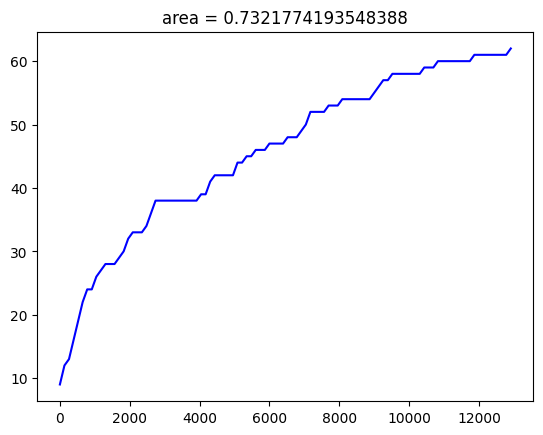

In [186]:
values, base = np.histogram(test_result, bins=100)
cumulative = np.cumsum(values)
plt.title('area = ' + str(np.trapz(cumulative/cumulative[-1], dx=1/len(cumulative))))
plt.plot(base[:-1], cumulative, c='blue')
plt.show()
area = np.trapz(cumulative/62, dx=1/len(cumulative))

In [187]:
from sklearn.inspection import permutation_importance

In [190]:
def importance_test(positive, negative, trials, isks, num_left=None):
    section = len(positive)/trials
    out = []
    
    for i in range(trials):
        df = pd.concat([positive.drop(range(round(i*section), round((i+1)*section))), 
                   negative.sample(n=(len(positive)-round(section)))])

        # Split the dataset into features (X) and target variable (y)
        X = df.drop(['oncogene', 'gene name'], axis=1)
        y = df['oncogene']
        
        if isks:
            if num_left is None:
                num_left = len(df)
                
            p_val = [-1]
            for j in range(1, len(df.columns)):
                _, p_value = stats.kstest(df.iloc[:,j], stats.norm.cdf)
                p_val.append(p_value)
                
            num = len(p_val)-num_left
            drop_ind = np.argpartition(p_val, -(num))[-(num):]
            df.drop(df.columns[drop_ind], axis=1, inplace=True)
            
        # Create an SVM classifier
        model = SVR().fit(X, y)
        results = permutation_importance(model, X, y, n_repeats=10)
        # get importance
        importance = results.importances_mean
        # plot feature importance
        plt.bar([x for x in range(len(importance))], importance)
        plt.show()
        out.append(model)
    
    return out

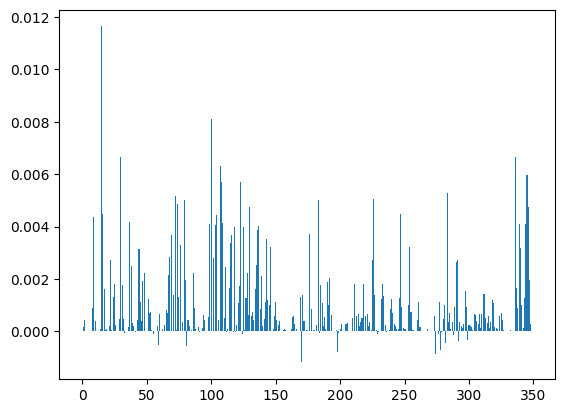

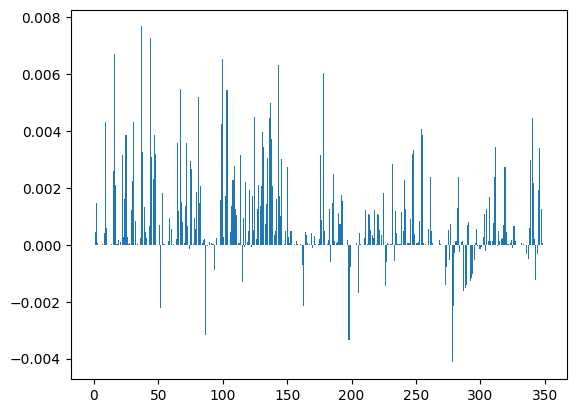

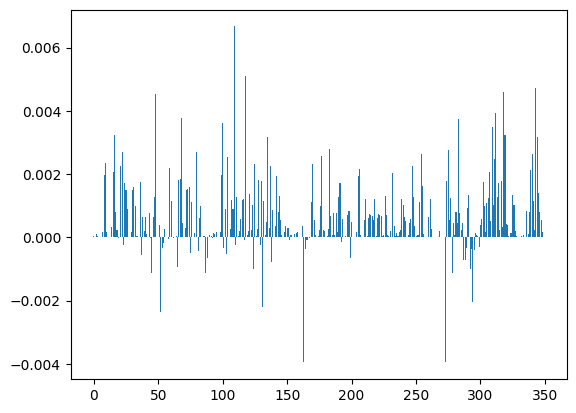

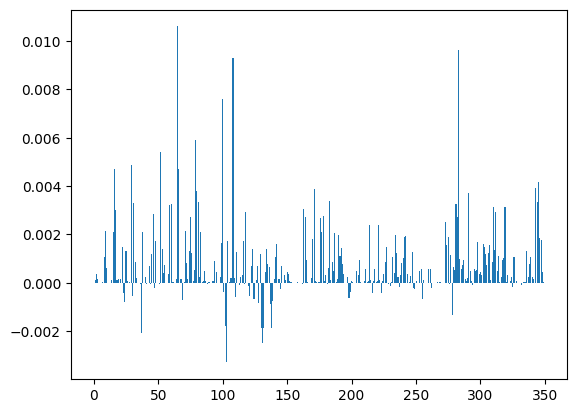

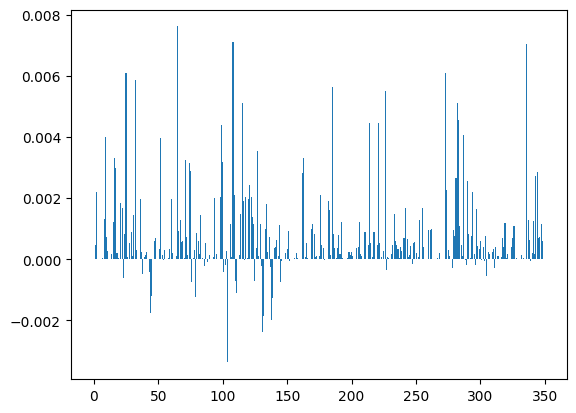

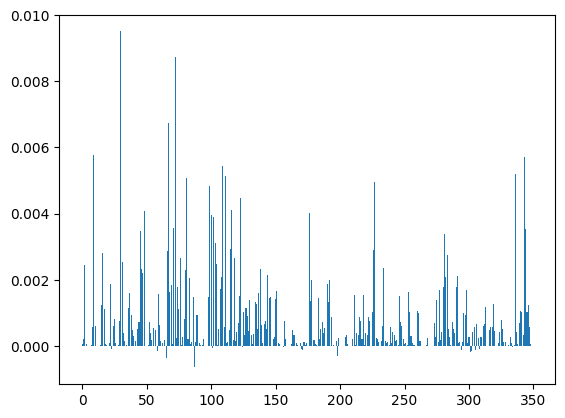

[SVR(), SVR(), SVR(), SVR(), SVR(), SVR()]

In [191]:
importance_test(positive, negative, 6, True)

In [154]:
temp = pd.DataFrame()
for i in range(3):
    temp = pd.concat([temp, pd.DataFrame({'feature ' + str(i):np.random.normal(size=100)})], axis=1)
temp = pd.concat([temp, pd.DataFrame({'Result':temp.iloc[:,0]+temp.iloc[:,1]})], axis=1)
temp

,feature 0,feature 1,feature 2,Result
0,-0.005394,0.642843,0.747610,0.637449
1,0.815514,-0.572401,0.640938,0.243113
2,0.344519,0.140312,-0.866948,0.484831
3,-0.434726,-0.770942,-0.178466,-1.205668
4,-0.434799,-0.391312,-1.005049,-0.826111
...,...,...,...,...
95,-1.796171,0.765324,-0.589331,-1.030846
96,-0.906008,-2.226683,0.236023,-3.132691
97,-1.491952,-1.468599,0.349194,-2.960551
98,-0.359808,-0.912014,-0.259104,-1.271822


In [161]:
model.predict([[1,1,0]])

C:\Users\justi\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


array([2.08121613])

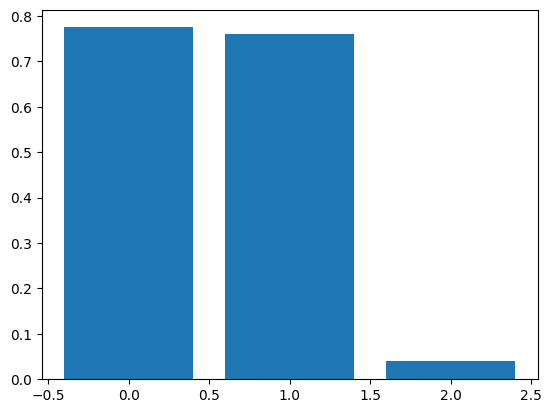

In [155]:
X = temp.drop(['Result'], axis=1)
y = temp['Result']

model = SVR().fit(X, y)
results = permutation_importance(model, X, y, n_repeats=20)
# get importance
importance = results.importances_mean
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()